In [7]:
import config
import json
import os
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from helpers import get_cm5_corrections_dict
from helpers import kallisto_molecule_from_rdkit_molecule
from helpers import MolsFromSpartanFiles
from helpers import get_SMARTS_matches

from jazzy.core import get_covalent_atom_idxs
from jazzy.core import calculate_polar_strength_map

from rdkit import IPythonConsole
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
IPythonConsole.drawOptions.annotationFontScale = 0.75

# Import load files for input
data_path = os.path.abspath(os.path.join(os.getcwd(), "..", config.DATA_PATH))
optuna_path = os.path.join(data_path, config.OPTUNA_DIRNAME)
params_filepath = os.path.join(optuna_path, config.OPTUNA_CM5_PARAMETERS_FILENAME)
original_dataset_filepath = os.path.join(
    data_path, config.MOLS_DIRNAME, config.ORIGINAL_DATA_FILENAME
)
pkbhx_filepath = os.path.join(
    data_path, config.MOLS_DIRNAME, config.PKBHX_DATA_FILENAME
)

# Load in molecules with MP2/6-31G* CHELPG charges and pKBHX
mols = MolsFromSpartanFiles(original_dataset_filepath)
pkbhx = np.genfromtxt(pkbhx_filepath)

# Identify molecules affected by NO, PO and SO CM5 pairwise corrections
smarts_matches = get_SMARTS_matches(config.FITTING_SMARTS, mols)

# Create modified CM5 dictionary
CM5_ATOMIC_PARAMETERS = config.CM5_PARAMETERS_UNMODIFIED
modified_CM5_PARAMETERS = deepcopy(CM5_ATOMIC_PARAMETERS)
with open(params_filepath) as f:
    best_params = json.load(f)

modified_CM5_PARAMETERS[("N","O")] = best_params["NO"]
modified_CM5_PARAMETERS[("O","P")] = best_params["PO"]
modified_CM5_PARAMETERS[("O","S")] = best_params["SO"]

# Calculate strongest SA for each molecule with corrected and uncorrected CM5 charges
qm_sa = []
kallisto_sa = []
cm5_sa = []
cm5_corr_sa = []

# Initialize charge lists if they are not already defined
qm_charge_list = []
kallisto_charge_list = []
cm5_charge_list = []
cm5_corr_charge_list = []

for mol in mols:
    # Get kallisto molecule and variables
    kallisto_molecule = kallisto_molecule_from_rdkit_molecule(mol)   
    at = kallisto_molecule.get_atomic_numbers()
    coords = kallisto_molecule.get_positions()
    atoms_and_nbrs = get_covalent_atom_idxs(mol)
    
    # Calculate charges
    # qm_charges = np.array([float(atom.GetProp("_TriposPartialCharge")) for atom in mol.GetAtoms()])
    qm_charges = np.array([float(x) for x in mol.GetProp("chelpg_charges").split(",")])
    kallisto_charges = kallisto_molecule.get_eeq(0)
    cm5_correction = get_cm5_corrections_dict(at, coords, CM5_ATOMIC_PARAMETERS=CM5_ATOMIC_PARAMETERS)
    new_cm5_correction = get_cm5_corrections_dict(at, coords, CM5_ATOMIC_PARAMETERS=modified_CM5_PARAMETERS)
    cm5_charges = kallisto_charges + cm5_correction
    cm5_corr_charges = kallisto_charges + new_cm5_correction

    # Calculate Strengths
    qm_strengths = calculate_polar_strength_map(mol, kallisto_molecule, atoms_and_nbrs, list(qm_charges))
    kallisto_strengths = calculate_polar_strength_map(mol, kallisto_molecule, atoms_and_nbrs, list(kallisto_charges))
    cm5_strengths = calculate_polar_strength_map(mol, kallisto_molecule, atoms_and_nbrs, list(cm5_charges), a=-1.4591, d=4.0196)
    cm5_corr_strengths = calculate_polar_strength_map(mol, kallisto_molecule, atoms_and_nbrs, list(cm5_corr_charges), a=-1.4591, d=4.0196)

    # Append max sa to lists
    qm_sa.append(max([qm_strengths[x]["sa"] for x in qm_strengths.keys()]))    
    kallisto_sa.append(max([kallisto_strengths[x]["sa"] for x in kallisto_strengths.keys()]))
    cm5_sa.append(max([cm5_strengths[x]["sa"] for x in cm5_strengths.keys()]))  
    cm5_corr_sa.append(max([cm5_corr_strengths[x]["sa"] for x in cm5_corr_strengths.keys()]))  

    # Append charges to the respective lists
    qm_charge_list.append(qm_charges)
    kallisto_charge_list.append(kallisto_charges)
    cm5_charge_list.append(cm5_charges)
    cm5_corr_charge_list.append(cm5_corr_charges)

# Convert to numpy arrays
qm_sa = np.array(qm_sa)
kallisto_sa = np.array(kallisto_sa)
cm5_sa = np.array(cm5_sa)
cm5_corr_sa = np.array(cm5_corr_sa)

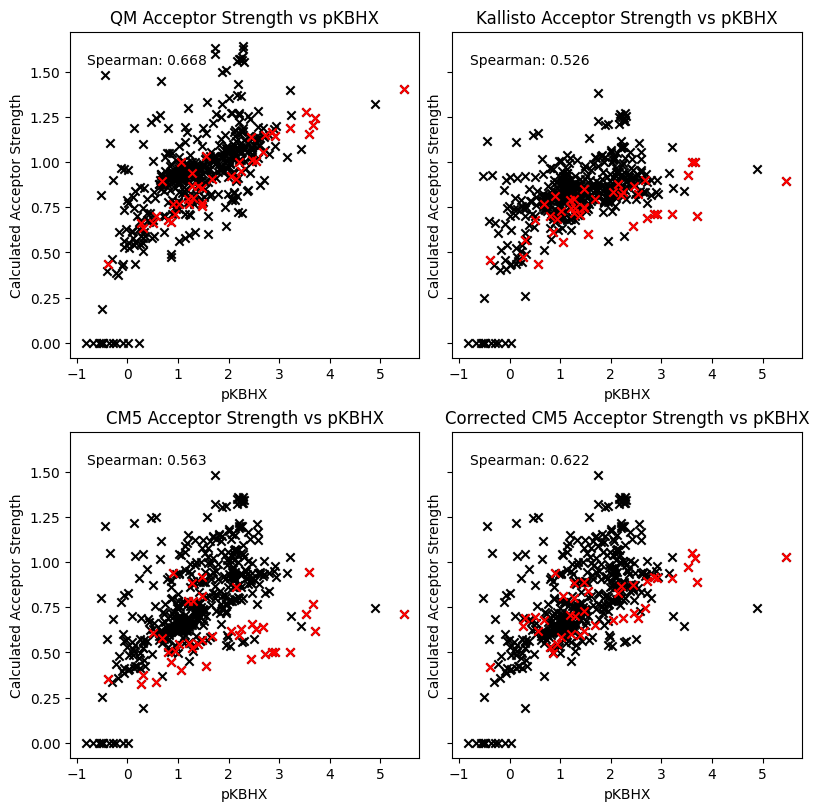

In [8]:
from scipy import stats
# Calculate spearman and plot graphs

fig, axs = plt.subplots(2,2,figsize=(8,8), layout="constrained", sharey=True)
titles = ["QM Acceptor Strength vs pKBHX",
        "Kallisto Acceptor Strength vs pKBHX",
        "CM5 Acceptor Strength vs pKBHX",
        "Corrected CM5 Acceptor Strength vs pKBHX",]
for i,(ax, sa) in enumerate(zip(axs.flatten(), [qm_sa, kallisto_sa, cm5_sa, cm5_corr_sa])):
    ax.scatter(pkbhx, sa, marker = "x", color="black")
    ax.scatter(pkbhx[smarts_matches], sa[smarts_matches],  marker="x", color="red", label="SMARTS matches")
    ax.set_title(titles[i])
    ax.set_ylabel("Calculated Acceptor Strength")
    ax.set_xlabel("pKBHX")
    ax.text(0.05,0.9,"Spearman: {:.3f}".format(stats.spearmanr(sa, pkbhx)[0]), transform=ax.transAxes)

In [9]:
display_mols = []
for j in np.array(smarts_matches)[[39,24,25,1,30,23,34,9,6]]:
    mol1 = deepcopy(mols[j])
    AllChem.Compute2DCoords(mol1)
    mol2 = deepcopy(mol1)
    mol3 = deepcopy(mol1)
    mol4 = deepcopy(mol1)

    qm_charges = [float(x) for x in mol1.GetProp("chelpg_charges").split(",")]
    k_charges = kallisto_charge_list[j]
    cm5_charges = cm5_charge_list[j]
    cm5_corr_charges = cm5_corr_charge_list[j]

    # Iterate over the atoms
    for i,atom in enumerate(mol1.GetAtoms()):
        # For each atom, set the property "atomNote" to a index+1 of the atom
        atom.SetProp("atomNote", "{:.2f}".format(qm_charges[i]))
    for i,atom in enumerate(mol2.GetAtoms()):
        # For each atom, set the property "atomNote" to a index+1 of the atom
        atom.SetProp("atomNote", "{:.2f}".format(k_charges[i]))
    for i,atom in enumerate(mol3.GetAtoms()):
        # For each atom, set the property "atomNote" to a index+1 of the atom
        atom.SetProp("atomNote", "{:.2f}".format(cm5_charges[i]))
    for i,atom in enumerate(mol4.GetAtoms()):
        # For each atom, set the property "atomNote" to a index+1 of the atom
        atom.SetProp("atomNote", "{:.2f}".format(cm5_corr_charges[i]))
    display_mols += [mol1, mol2, mol3, mol4]

svg = Chem.Draw.MolsToGridImage(display_mols, subImgSize=(350,250), molsPerRow=4, useSVG=True)

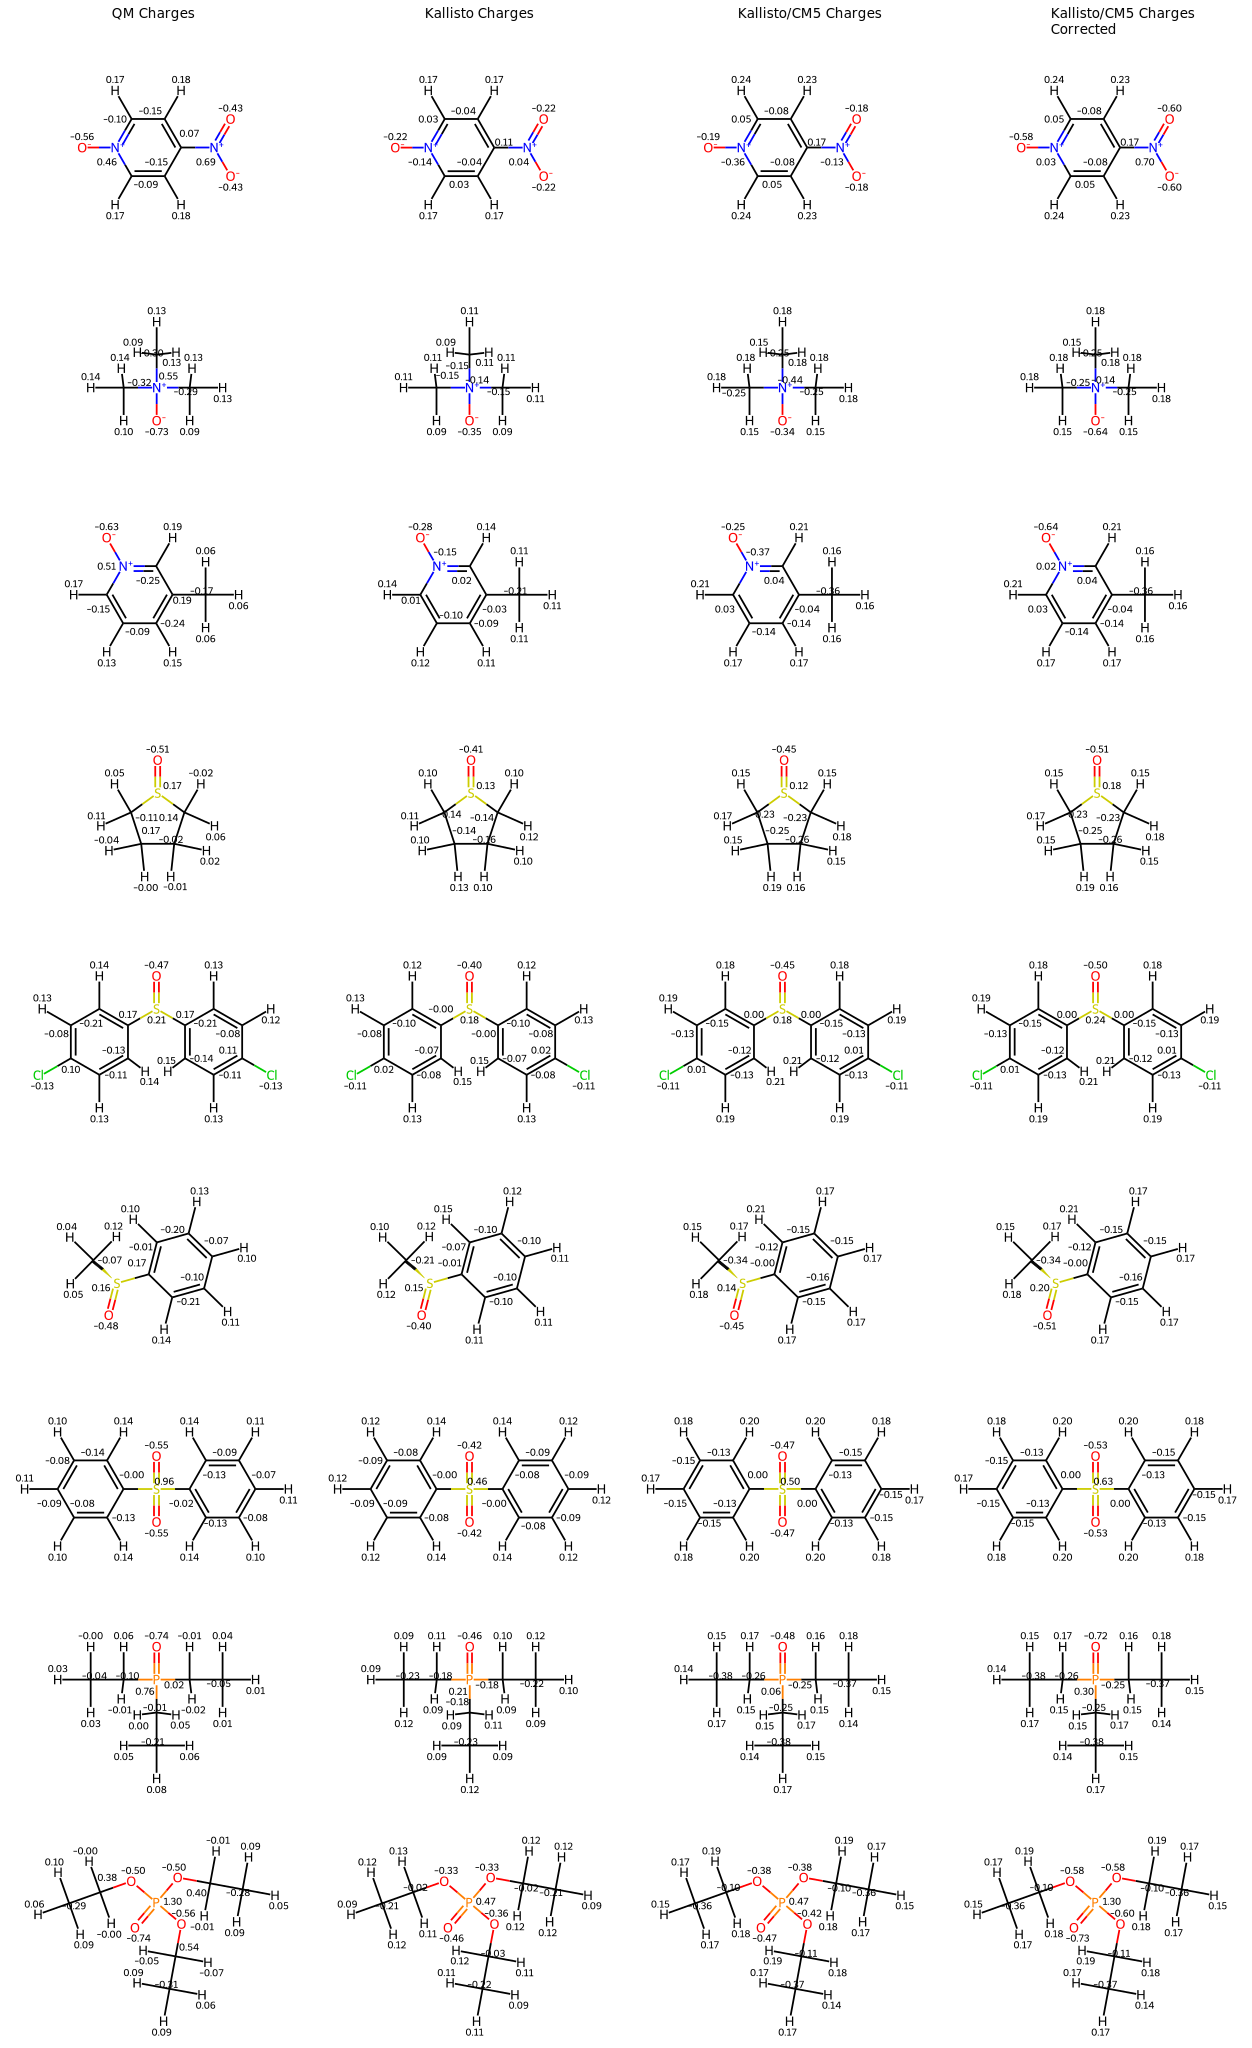

In [10]:
from IPython.core.display import SVG

# Define the SVG string with four evenly spaced text boxes at the top
svg_string = '''
<svg width="1400" height="50" xmlns="http://www.w3.org/2000/svg">
    <!-- Text boxes -->
    <text x="125" y="20" font-family="Verdana" font-size="15" fill="black">QM Charges</text>
    <text x="475" y="20" font-family="Verdana" font-size="15" fill="black">Kallisto Charges</text>
    <text x="825" y="20" font-family="Verdana" font-size="15" fill="black">Kallisto/CM5 Charges</text>
    <text x="1175" y="20" font-family="Verdana" font-size="15" fill="black">Kallisto/CM5 Charges
        <tspan x="1175" dy="1.2em">Corrected</tspan>
    </text>

</svg>
'''

# Create the SVG object
svg_object = SVG(svg_string)

# Combine the two SVGs into one SVG container
combined_svg = f'''
<svg width="1400px" height="2290px" xmlns="http://www.w3.org/2000/svg">
    <g transform="translate(0, 0)">
        {svg_string}
    </g>
    <g transform="translate(0, 40)">
        {svg.data}
    </g>
</svg>
'''

# Create the SVG object
combined_svg_object = SVG(combined_svg)

# Display the combined SVG object (if using a Jupyter notebook or similar environment)
display(combined_svg_object)